# *`MachineHack GIH LB Notebook`*

### This Notebook contains the Rank 26 solution to the The Great Indian Hiring Hackathon organized by MachineHack.

### Dataset Description:
 - Train.csv - 284780 rows x 8 columns (Inlcudes UnitPrice Columns as Target)
 - Test.csv - 122049 rows x 7 columns
 - Sample Submission.csv - Please check the Evaluation section for more details on how to generate a valid submission
 

### Attribute Description:
 1. Invoice No - Invoice ID, encoded as Label
 2. StockCode - Unique code per stock, encoded as Label
 3. Description - The Description, encoded as Label
 4. Quantity - Quantity purchased
 5. InvoiceDate - Date of purchase
 6. UnitPrice - The *Target value*, price of every product
 7. CustomerID - Unique Identifier for every Customer
 8. Country - Country of sales, encoded as Label

### Importing Libraries

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy import stats
from collections import Counter, defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRFRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer

### Reading Train & Test csv

In [2]:
train_df = pd.read_csv(r"Train.csv")
train_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


In [3]:
test_df = pd.read_csv(r"Test.csv")
test_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35


## EDA & Feature Engineering

In [4]:
train_df.describe()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
count,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000
mean,9955.394083,1573.386807,2023.955573,12.028468,3.451216,15288.224278,32.823846
std,5551.519138,843.604991,1089.812078,295.111588,78.399541,1714.336529,6.743602
min,0.000000,0.000000,0.000000,-80995.000000,0.000000,12346.000000,0.000000
25%,5069.000000,939.000000,1141.000000,2.000000,1.250000,13953.000000,35.000000
50%,10310.000000,1521.000000,1987.000000,5.000000,1.950000,15152.000000,35.000000
75%,14657.000000,2106.000000,2945.000000,12.000000,3.750000,16794.000000,35.000000
max,22188.000000,3683.000000,3895.000000,80995.000000,38970.000000,18287.000000,36.000000


In [5]:
test_df.describe()

,InvoiceNo,StockCode,Description,Quantity,CustomerID,Country
count,122049.000000,122049.000000,122049.000000,122049.000000,122049.000000,122049.000000
mean,9940.419692,1572.955788,2026.412744,12.137920,15286.445256,32.836795
std,5554.116349,845.106082,1087.697388,54.311646,1711.887591,6.726816
min,0.000000,0.000000,0.000000,-9360.000000,12347.000000,0.000000
25%,5018.000000,937.000000,1147.000000,2.000000,13953.000000,35.000000
50%,10311.000000,1523.000000,1987.000000,5.000000,15152.000000,35.000000
75%,14635.000000,2106.000000,2945.000000,12.000000,16782.000000,35.000000
max,22189.000000,3683.000000,3895.000000,4800.000000,18287.000000,36.000000


In [6]:
train_df[train_df["StockCode"]==510]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
3847,14606,510,3457,2,2011-10-24 17:07:00,0.83,14096.0,35
8530,139,510,3457,12,2010-12-02 10:17:00,1.25,13941.0,35
15351,7351,510,3457,2,2011-05-29 14:08:00,1.25,16686.0,35
16479,17524,510,3457,13,2011-11-28 15:54:00,0.83,14096.0,35
25176,4638,510,3457,12,2011-03-30 15:38:00,1.25,16092.0,35
29943,11275,510,3457,12,2011-08-26 10:50:00,1.25,14911.0,10
33532,15081,510,3457,2,2011-10-31 14:09:00,0.83,14096.0,35
37525,15896,510,3457,1,2011-11-10 12:37:00,0.83,14096.0,35
41441,17243,510,3457,1,2011-11-24 13:54:00,1.25,14606.0,35
42080,11813,510,3457,24,2011-09-08 12:47:00,1.25,15306.0,35


In [7]:
train_df[train_df["CustomerID"]==13941.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
458,2861,263,480,24,2011-02-15 12:12:00,2.95,13941.0,35
3655,139,2753,205,20,2010-12-02 10:17:00,2.55,13941.0,35
7482,11929,2753,205,6,2011-09-11 12:00:00,2.95,13941.0,35
8530,139,510,3457,12,2010-12-02 10:17:00,1.25,13941.0,35
21789,8374,3300,573,256,2011-06-21 09:44:00,0.36,13941.0,35
29317,20595,1074,2941,-21,2011-07-19 15:47:00,5.95,13941.0,35
31301,11929,2684,1480,72,2011-09-11 12:00:00,1.25,13941.0,35
63578,2861,1074,2940,6,2011-02-15 12:12:00,6.75,13941.0,35
73275,16636,2291,2056,96,2011-11-18 09:43:00,3.29,13941.0,35
87707,139,2755,725,24,2010-12-02 10:17:00,4.25,13941.0,35


In [8]:
common_stockcodes = test_df["StockCode"][train_df["StockCode"] & test_df["StockCode"]]
common_stockcodes

0         1709
1          510
3         1478
4         3216
5         1817
          ... 
122044    2487
122045    3069
122046    1419
122047    1631
122048    2088
Name: StockCode, Length: 117038, dtype: int64

In [9]:
train_df[(train_df["InvoiceNo"]==3139) & (train_df["StockCode"]==1709)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


['2011-05-26 12:52:00',
 '2011-11-21 12:02:00',
 '2011-07-27 12:38:00',
 '2011-01-26 14:35:00',
 '2011-07-18 12:15:00',
 '2011-11-02 16:16:00',
 '2011-06-21 15:13:00',
 '2011-01-05 10:08:00',
 '2011-02-28 15:19:00',
 '2011-05-25 12:44:00',
 '2011-11-22 12:58:00',
 '2011-04-07 10:09:00',
 '2010-12-23 14:40:00',
 '2011-12-04 14:55:00',
 '2011-01-09 14:11:00',
 '2011-09-11 15:59:00',
 '2011-08-08 12:11:00',
 '2011-07-29 15:42:00',
 '2011-03-11 16:43:00',
 '2011-11-03 14:22:00',
 '2011-05-23 13:09:00',
 '2011-11-01 15:06:00',
 '2011-05-20 12:25:00',
 '2011-11-08 14:53:00',
 '2011-09-27 09:46:00',
 '2011-01-28 14:53:00',
 '2011-11-15 11:56:00',
 '2011-07-13 15:29:00',
 '2011-10-05 14:19:00',
 '2011-05-22 11:29:00',
 '2011-04-07 10:38:00',
 '2011-08-11 17:14:00',
 '2011-01-31 10:09:00',
 '2011-03-11 09:54:00',
 '2011-04-21 08:43:00',
 '2011-12-05 12:44:00',
 '2011-02-17 14:36:00',
 '2011-08-15 12:08:00',
 '2010-12-10 13:52:00',
 '2011-02-16 10:33:00',
 '2011-03-28 09:16:00',
 '2011-04-08 08:

In [14]:
for feature in test_df.columns:
    match = 0
    mismatch = 0
    a = list(set(train_df[feature]))
    b = list(set(test_df[feature]))
    for i in b:
        if i in a:
            match+=1
        else:
    #         print(i)
            mismatch+=1
    print("{}:: match: {}, mismatch: {}".format(feature, match, mismatch))

InvoiceNo:: match: 16985, mismatch: 1219
StockCode:: match: 3345, mismatch: 65
Description:: match: 3486, mismatch: 77
Quantity:: match: 211, mismatch: 63
InvoiceDate:: match: 16020, mismatch: 1009
CustomerID:: match: 4193, mismatch: 33
Country:: match: 37, mismatch: 0


#### We can infer from the above cell results that using InvoiceNo & InvoiceDate will lead to poor results as the are incosistent over the Train and Test datasets

<AxesSubplot:>

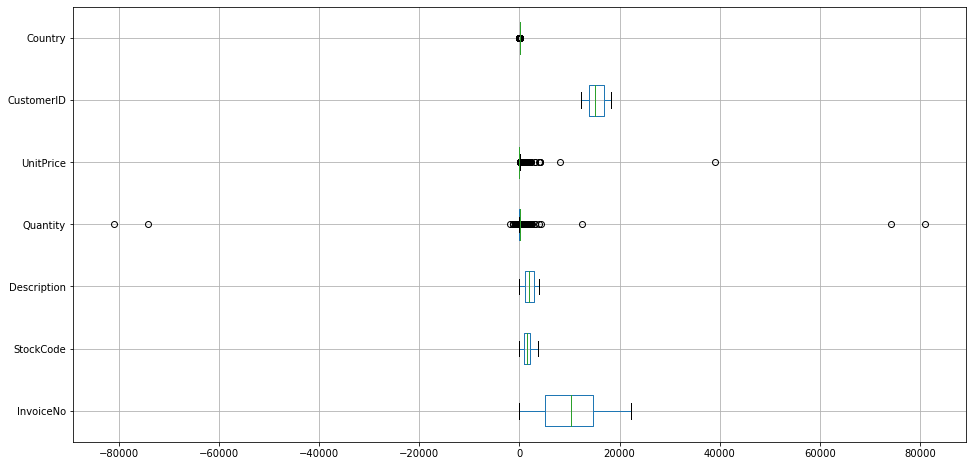

In [15]:
# construct box plot for continuous variables
plt.figure(figsize=(16,8))
train_df.boxplot(vert=0)

#### We can see that Quantity has negative values and has outliers of values around 80000, UnitPrice has outliers of values around 40000

In [16]:
# Replace the negative value of Quantity with abs value
train_df.loc[train_df["Quantity"]<0,"Quantity"]= abs(train_df["Quantity"])
# Coverting CustomerID from float to int to reduce memory usage
train_df["CustomerID"] = train_df["CustomerID"].astype("int")

<AxesSubplot:>

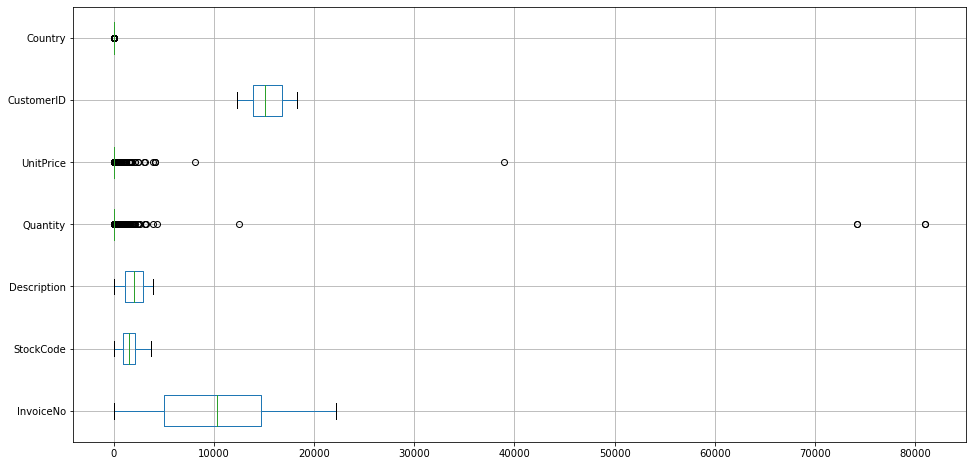

In [17]:
# construct box plot for continuous variables
plt.figure(figsize=(16,8))
train_df.boxplot(vert=0)

#### Lets drop duplicates before processing for outliers

In [18]:
print("Before Duplicates Dropped:", len(train_df))
train_df.drop_duplicates(subset=["StockCode", "Description", "Quantity", "CustomerID"], inplace=True)
print("After Duplicates Dropped:", len(train_df))

Before Duplicates Dropped: 284780
After Duplicates Dropped: 239387


#### Removing outliers using 2.5 times standard deviation

In [19]:
def remove_outliers(df, column):
#     for column in list(df.columns):
    if df[column].dtype == "int64" or df[column].dtype == "float64":
        mean = df[column].mean()
        sd = df[column].std()
        q = sd*2.5
        print("{}: stdev: {}, +/-*2.5: {}".format(column, sd, q))
#             print("          q1: {}, q2: {}".format(q1, q2))
        df = df[(df[column]>=mean-q) & (df[column]<=mean+q)]
    return df

In [20]:
print("Before filter:", len(train_df))
train_df = remove_outliers(train_df, "UnitPrice")
print("After filter:", len(train_df))

Before filter: 239387
UnitPrice: stdev: 83.2918887484725, +/-*2.5: 208.22972187118125
After filter: 239341


<AxesSubplot:xlabel='UnitPrice', ylabel='Count'>

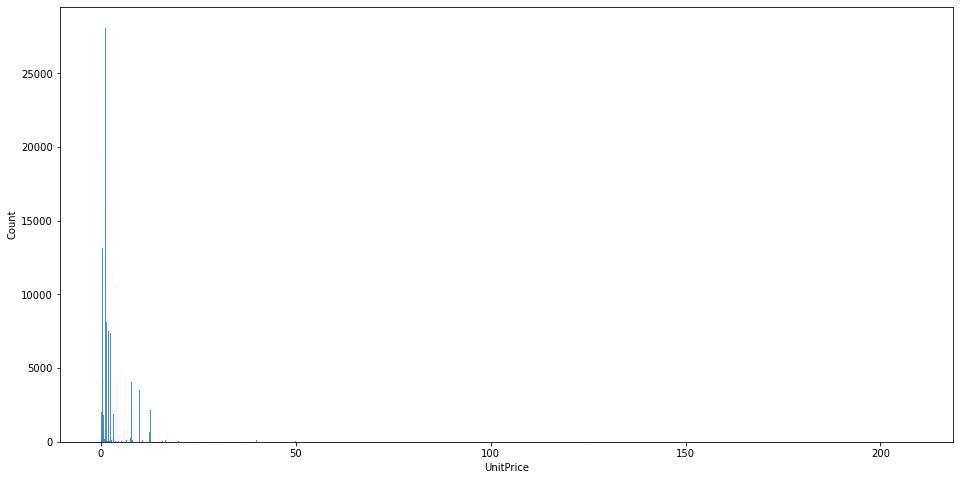

In [21]:
# construct box plot for continuous variables
plt.figure(figsize=(16,8))
sns.histplot(x=train_df["UnitPrice"])

<AxesSubplot:xlabel='UnitPrice', ylabel='Count'>

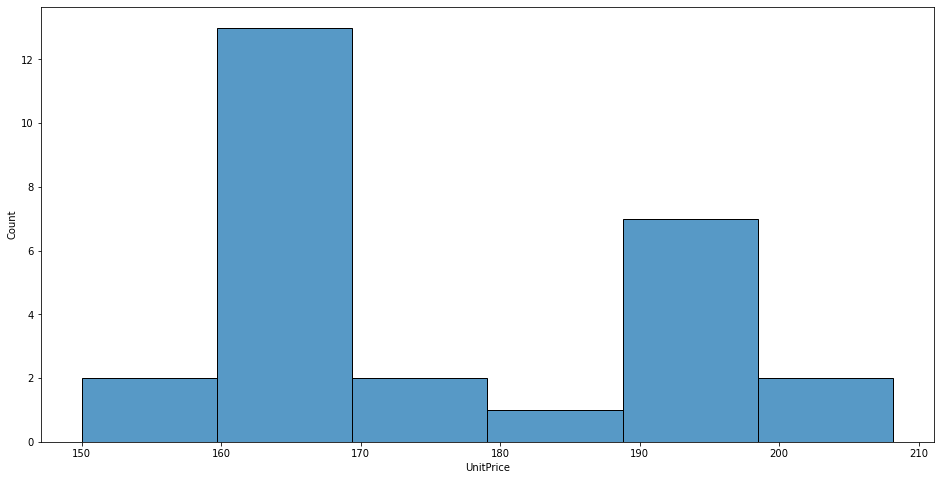

In [22]:
plt.figure(figsize=(16,8))
sns.histplot(train_df["UnitPrice"][train_df["UnitPrice"]>=150])

In [23]:
train_df["UnitPrice"].mean()

2.934422284522919

#### We can see that unit price is centered around a mean of 3

In [24]:
train_df.sort_values(by=['CustomerID'], inplace=True) #sorting so that UnitPrices are more randomized

#### Coverting InvoiceDate to datetime column & extracting features from the same

In [25]:
train_df["InvoiceDate"] = pd.to_datetime(train_df["InvoiceDate"])
train_df["InvoiceDate_year"] = pd.to_datetime(train_df["InvoiceDate"]).dt.year
train_df["InvoiceDate_month"] = pd.to_datetime(train_df["InvoiceDate"]).dt.month
train_df["InvoiceDate_Dayofweek"] = pd.to_datetime(train_df["InvoiceDate"]).dt.dayofweek
train_df["InvoiceDate_Day"] = pd.to_datetime(train_df["InvoiceDate"]).dt.day
train_df["InvoiceDate_Hour"] = pd.to_datetime(train_df["InvoiceDate"]).dt.hour

#Finding maximum date in the data
maximum = max(train_df.InvoiceDate)

#Adding one more day to the max date, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days = 1)
train_df['diff'] = maximum - train_df.InvoiceDate
train_df["diff"] = train_df["diff"].dt.days
train_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_Dayofweek,InvoiceDate_Day,InvoiceDate_Hour,diff
141379,1909,2001,2002,74215,2011-01-18 10:01:00,1.04,12346,35,2011,1,1,18,10,326
117895,7844,2008,2790,2,2011-06-09 13:01:00,9.95,12347,16,2011,6,3,9,13,183
84850,548,206,357,12,2010-12-07 14:57:00,4.65,12347,16,2010,12,1,7,14,367
214290,548,3287,366,30,2010-12-07 14:57:00,1.25,12347,16,2010,12,1,7,14,367
257445,2205,1035,2055,12,2011-01-26 14:30:00,0.42,12347,16,2011,1,2,26,14,317


In [26]:
#finding correalation in df
train_df.corr()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_Dayofweek,InvoiceDate_Day,InvoiceDate_Hour,diff
InvoiceNo,1.000000,0.090304,0.027127,-0.000237,-0.015554,-0.008070,0.010015,0.425090,0.646047,0.000527,0.086985,0.049190,-0.944104
StockCode,0.090304,1.000000,-0.010720,0.001308,0.081390,0.006085,0.013709,0.034812,0.068101,0.005176,0.006208,0.004893,-0.091243
Description,0.027127,-0.010720,1.000000,0.000814,-0.004063,-0.007283,-0.013210,0.025376,0.009320,0.002325,0.006123,-0.003331,-0.029435
Quantity,-0.000237,0.001308,0.000814,1.000000,-0.016397,-0.005372,-0.009808,0.001811,-0.002602,-0.006115,-0.000617,-0.012389,0.001027
UnitPrice,-0.015554,0.081390,-0.004063,-0.016397,1.000000,-0.023288,-0.033604,-0.013248,-0.027578,-0.012532,-0.002400,-0.007763,0.036272
CustomerID,-0.008070,0.006085,-0.007283,-0.005372,-0.023288,1.000000,0.401581,-0.040105,0.030676,0.018767,0.000623,0.069426,0.003764
Country,0.010015,0.013709,-0.013210,-0.009808,-0.033604,0.401581,1.000000,-0.017851,0.028361,0.038709,0.001345,0.105732,-0.012180
InvoiceDate_year,0.425090,0.034812,0.025376,0.001811,-0.013248,-0.040105,-0.017851,1.000000,-0.341305,-0.015769,0.168874,-0.021373,-0.503572
InvoiceDate_month,0.646047,0.068101,0.009320,-0.002602,-0.027578,0.030676,0.028361,-0.341305,1.000000,0.025065,-0.119316,0.055186,-0.637091
InvoiceDate_Dayofweek,0.000527,0.005176,0.002325,-0.006115,-0.012532,0.018767,0.038709,-0.015769,0.025065,1.000000,-0.002510,0.036400,-0.010253


#### As expected Stockcode has the most corealation with UnitPrice

F:\Anaconda\envs\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='StockCode', ylabel='UnitPrice'>

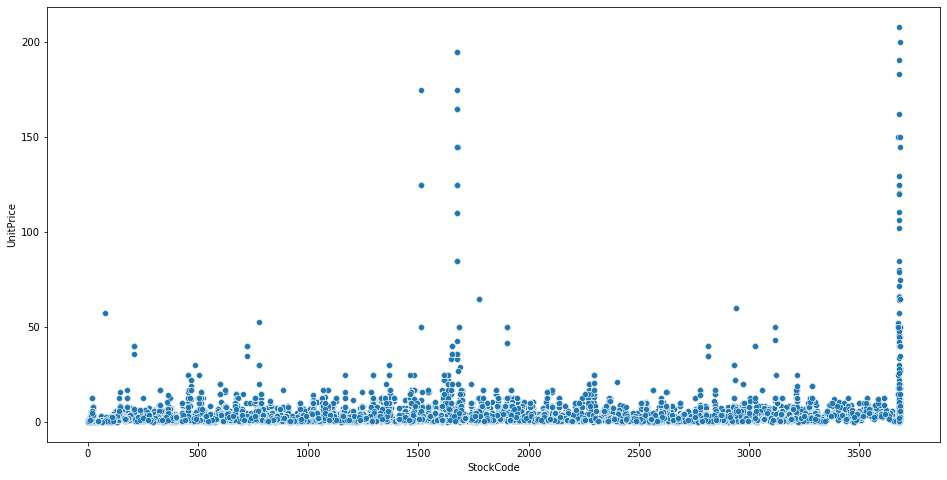

In [27]:
plt.figure(figsize=(16,8))
sns.scatterplot(train_df["StockCode"], train_df["UnitPrice"])

#### From the above plot it can be infered that the UnitPrices are mostly concentrated towards the mean value and has higher values for a few StockCodes

<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

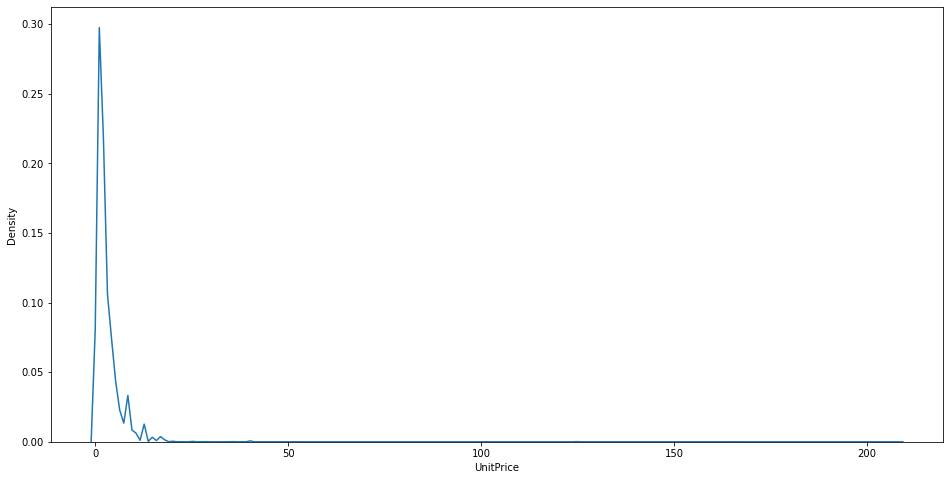

In [35]:
#checking for the distribution in the UnitPrice
# not checking normal distribution for other features except UnitPrice as it is the only continious value other than quantity
plt.figure(figsize=(16,8))
sns.kdeplot(train_df["UnitPrice"])

### After ploting KDE we can see that the UnitPrice distribution is not normal and hence it needs to be normalized

In [36]:
# we need to seprate train_df into train and test datasets before we start normalizing the data

### Splitting Data into Train & Test sets for Training model

In [37]:
seed = np.random.random_integers(0, 99999)
print("Random State:", seed)

x = train_df.loc[:, ['StockCode', 'Description', 'Quantity', 'CustomerID', 'Country']] #Random State: 57528 LB: 23.04894
y = train_df["UnitPrice"]
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, random_state=seed, test_size=0.1)

Random State: 91336


F:\Anaconda\envs\opencv\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 99999 + 1) instead
  """Entry point for launching an IPython kernel.


In [39]:
pt = PowerTransformer()
#transform data
x_train_pt = pt.fit_transform(x_train)
x_test_pt = pt.transform(x_test)

pt_y = PowerTransformer() 
#PowerTransformer requires a matrix/DataFrame hence using .to_frame() to convert 1D data to 2D
y_train_pt = pt_y.fit_transform(y_train.to_frame()) 
y_test_pt = pt_y.transform(y_test.to_frame())

In [40]:
y_pt = pd.DataFrame(y_train_pt, columns=["UnitPrice"])
y_pt.head()

,UnitPrice
0,-1.068337
1,-0.938095
2,-1.365723
3,0.798259
4,-0.149277


<AxesSubplot:xlabel='UnitPrice', ylabel='Density'>

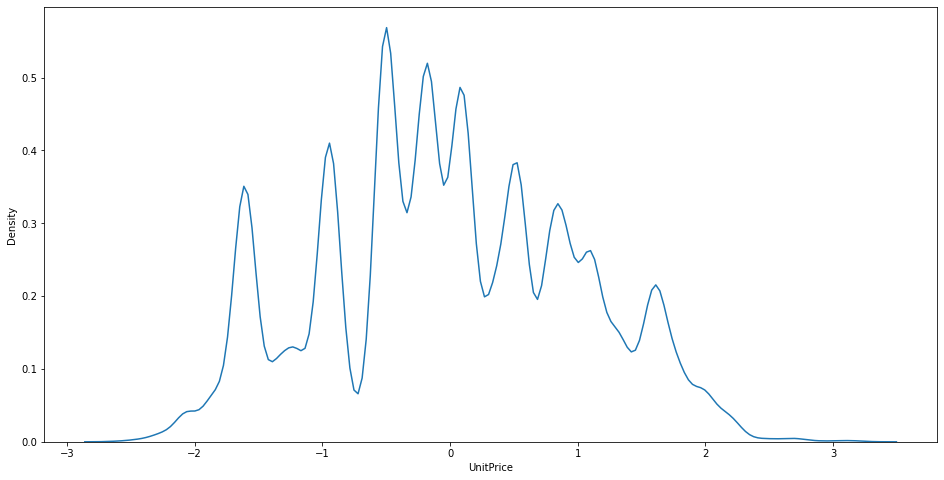

In [41]:
#visualizing Normalized UnitPrice Data distribution
plt.figure(figsize=(16,8))
sns.kdeplot(y_pt["UnitPrice"])

#### As we can see from the above graph the UnitPrice data is now much better normalized than before

## Model Training

In [42]:
xgb = XGBRFRegressor(max_depth=25,
    learning_rate=1,
    n_estimators=1000,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.8,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=0.8,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

In [43]:
xgb.fit(x_train_pt, y_train_pt)

XGBRFRegressor(max_depth=25, n_estimators=1000, n_jobs=-1,
               objective='reg:squarederror')

In [44]:
y_pred_pt = xgb.predict(x_test_pt)
rmse = np.sqrt(mean_squared_error(y_pred_pt, y_test_pt)) #oob True
r2 = r2_score(y_pred_pt, y_test_pt)
print("rmse: {}, r2: {}".format(rmse, r2))

rmse: 0.23502033732469116, r2: 0.9377971565448132


#### Note: Here im not inverse transforming the output as i have transformed y_test as well for final submission must do inverse transform on output

In [45]:
cval_T = cross_val_score(xgb,x,y, cv=5, n_jobs=-1, verbose=1)
cval_T, cval_T.sum()/5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 26.3min remaining: 39.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.6min finished


(array([0.81634141, 0.83038938, 0.87689754, 0.87901574, 0.756182  ]),
 0.8317652147826807)

In [46]:
cval = cross_val_score(xgb,x_test,y_test, cv=5, n_jobs=-1, verbose=1)
cval, cval.sum()/5

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


(array([0.7650079 , 0.53672904, 0.68916919, 0.58734993, 0.80793603]),
 0.6772384187735453)

In [47]:
(cval_T.sum()+cval.sum())/2

3.772509083890565

# Test DF & Output

In [48]:
test_df = pd.read_csv(r"Test.csv")
test_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35


In [49]:
test_df["InvoiceDate"] = pd.to_datetime(test_df["InvoiceDate"])
test_df["InvoiceDate_year"] = pd.to_datetime(test_df["InvoiceDate"]).dt.year
test_df["InvoiceDate_month"] = pd.to_datetime(test_df["InvoiceDate"]).dt.month
test_df["InvoiceDate_Dayofweek"] = pd.to_datetime(test_df["InvoiceDate"]).dt.dayofweek
test_df["InvoiceDate_Day"] = pd.to_datetime(test_df["InvoiceDate"]).dt.day
test_df["InvoiceDate_Hour"] = pd.to_datetime(test_df["InvoiceDate"]).dt.hour

#Finding maximum date in the data
maximum = max(test_df.InvoiceDate)

#Adding one more day to the max date, so that the max date will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days = 1)
test_df['diff'] = maximum - test_df.InvoiceDate
test_df["diff"] = test_df["diff"].dt.days
test_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,InvoiceDate_year,InvoiceDate_month,InvoiceDate_Dayofweek,InvoiceDate_Day,InvoiceDate_Hour,diff
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011,2,1,22,15,290
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010,12,2,8,12,367
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011,10,1,25,13,45
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011,6,0,27,12,166
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011,11,6,6,16,33


In [50]:
X = test_df.loc[:, ['StockCode', 'Description', 'Quantity', 'CustomerID', 'Country']] #Random State: 57528 LB: 23.04894
X_pt = pt.transform(X)
Y_pred = xgb.predict(X_pt)

In [51]:
output = pd.DataFrame(Y_pred, columns=["UnitPrice"])
output["UnitPrice"] = pt_y.inverse_transform(pd.DataFrame(Y_pred))
output.head(10)

,UnitPrice
0,1.654675
1,1.252705
2,3.010334
3,1.628124
4,12.672167
5,1.617283
6,2.806538
7,2.434206
8,2.934873
9,4.198978


#### Checking for any missing values before wiriting to submission files

In [52]:
temp = output[output["UnitPrice"].isna()]
print(len(temp))
temp

0


,UnitPrice


In [53]:
#writing to csv file for submission
output.to_csv("MachineHack_GIH_Submission_LB.csv", index=False)

### Comparing output data distribution to the original training dataset before commiting to submission

F:\Anaconda\envs\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
F:\Anaconda\envs\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='StockCode', ylabel='UnitPrice'>

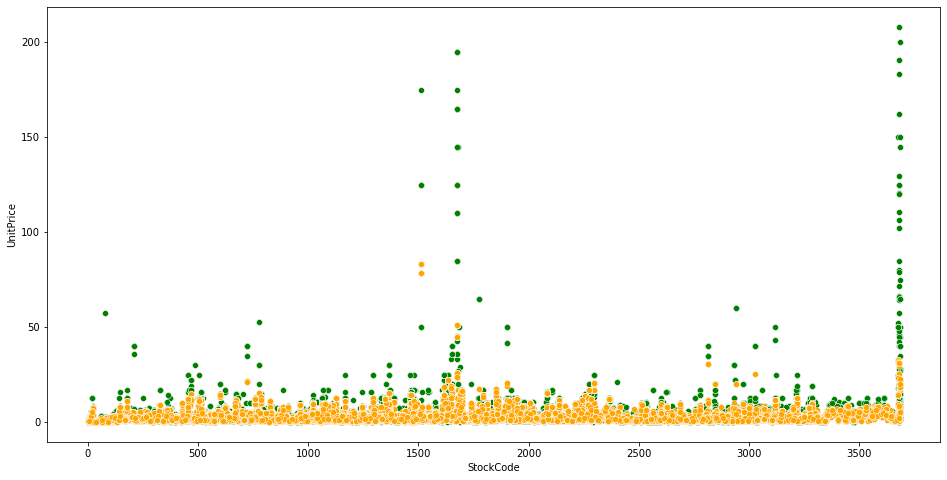

In [55]:
plt.figure(figsize=(16,8))
sns.scatterplot(train_df["StockCode"][train_df["UnitPrice"]<=10000], train_df["UnitPrice"][train_df["UnitPrice"]<=10000], color="green")
sns.scatterplot(test_df["StockCode"], output["UnitPrice"],  color="orange")

### Output distribution closly matches the train data sistribution hence commiting to submission.